In [7]:
import os
import re
from collections import defaultdict
from glob import glob
from os.path import *
from subprocess import check_call

import plotly.figure_factory as ff
import plotly.graph_objects as go
from ete3 import Tree
from plotly.subplots import make_subplots
from tqdm import tqdm
from collections import defaultdict
from ete3 import Tree
from IPython.display import display,Image
import pandas as pd
import plotly.express as px

In [ ]:
from final_params import *

In [5]:
from dating_workflow.toolkit.mcmctree_for import get_node_name_from_log,read_mcmc

In [15]:

from glob import glob
all_genes = glob('/mnt/ivy/thliao/project/AOB/analysis/20210713_repeat/add_Chromatiaces/phy_files/*prot/withEuk/*.aln') + glob('/mnt/ivy/thliao/project/AOB/analysis/20210713_repeat/add_Chromatiaces/phy_files/cog25_prot/*.aln')
all_genes = [_.split('/')[-1].replace('.aln','') for _ in all_genes]
genes = [[_ for _ in all_genes if _.startswith('NP')],
        [_ for _ in all_genes if _.startswith('Mito')],
         [_ for _ in all_genes if _.startswith('2')],]
genes.append(list(set(all_genes).difference(set([_ for v in genes for _ in v]))))  
gene_names = ['P39','M24','COG25','G18']
def get_gene_name(gene):
    for gn,g in zip(gene_names,genes):
        if gene in g:
            return gn
setname2genes = dict(zip(gene_names,genes))
gene2setname = {g:setname for setname,genes in setname2genes.items() for g in genes}

In [13]:
gene2num = {}
gene2dl = {}
for iqtree in glob(
    "/mnt/ivy/thliao/project/AOB/analysis/20210713_repeat/add_Chromatiaces/phy_files/*prot/withEuk/deltaLL/*.iqtree"
) + glob(
    "/mnt/ivy/thliao/project/AOB/analysis/20210713_repeat/add_Chromatiaces/phy_files/cog25_prot/deltaLL/*.iqtree"
):
    gene = iqtree.split("/")[-1].replace(".iqtree", "")
    rows = open(iqtree).read().strip().split("\n")
    idx = [idx for idx, v in enumerate(rows) if "deltaL  bp-RELL" in v][0]
    r1, r2 = rows[idx + 2], rows[idx + 3]
    r1 = [_ for _ in r1.strip().split(" ") if _]
    r2 = [_ for _ in r2.strip().split(" ") if _]
    if r2[2] == "0":
        gene2dl[gene] = float(r1[2])
    else:
        gene2dl[gene] = float(r2[2])
    gene2num[gene] = len(Tree(iqtree.replace(".iqtree", ".treefile")).get_leaf_names())
    

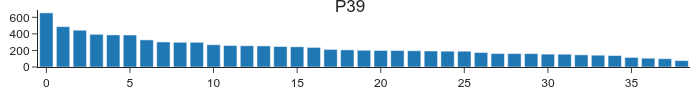

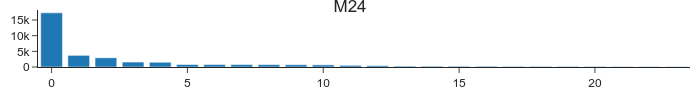

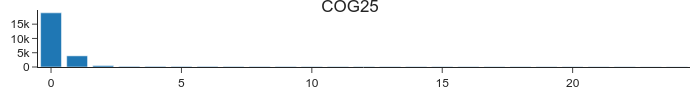

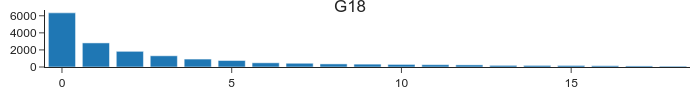

In [27]:
for setname,genes in setname2genes.items():
    dl_list = [gene2dl[_] for _ in genes]
    dl_list = sorted(dl_list,reverse=True)
    fig = go.Figure()
    fig.add_bar(y=dl_list)
    fig.update_layout(title_text=setname,title_x=0.5,title_y=1,width=700,height=100,template='simple_white',
                     margin_b=10,margin_l=10,margin_r=10,margin_t=10)
    display(Image(fig.to_image()))

100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


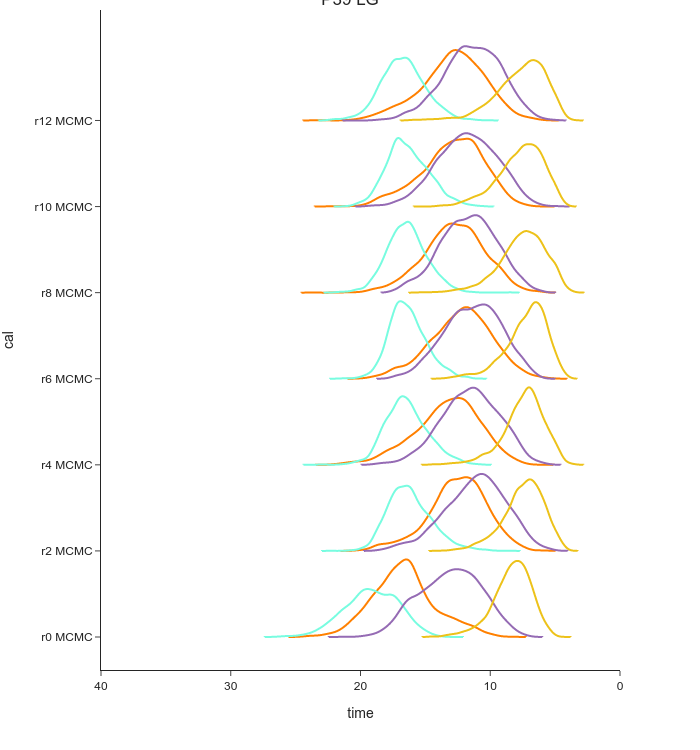

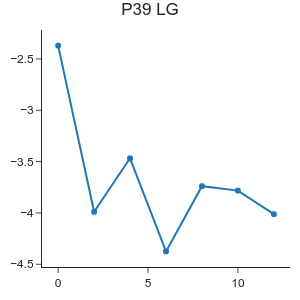

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


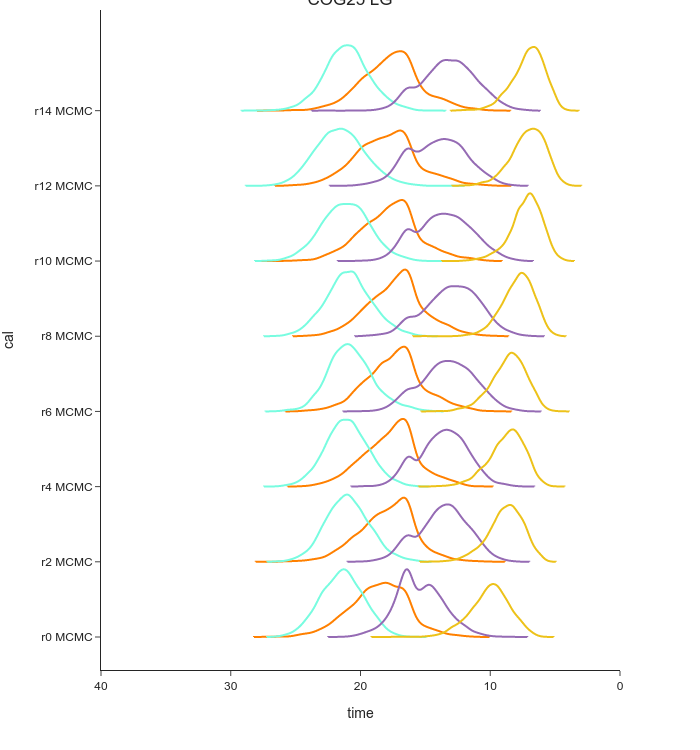

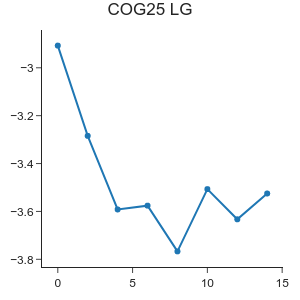

In [28]:
indir = '/mnt/ivy/thliao/project/AOB/analysis/20210713_repeat/add_Chromatiaces/refined_genes_DeltaL/stepwise'
for gene_set in ['P39','COG25']: #'M24','G18']:
    for _model in ['LG',
                   #'C60'
                  ]:
        t = []
        for f in glob(f'{indir}/{gene_set}/r*/1pf_{_model}/mcmctree/mcmc.txt'):
            if exists(f.replace('mcmc.txt','FigTree.tre')):
                t.append((f.split('/')[-4]+ ' MCMC',f))
        t = sorted(t,key=lambda x:int(x[0].split(' ')[0][1:]))
        t

        dfs = []
        targets = []
        for cal,mcmc in tqdm(t):
        #     if re.findall(f"_(B[1-9]+)",cal)[0] not in ['B1','B2','B3','B5']:
        #         continue
            tre= get_node_name_from_log(mcmc.replace('mcmc.txt','03_mcmctree.log'))
            df = read_mcmc(mcmc)
            try:
                df = df.sample(5000)
            except:
                print(mcmc)
            for lca,name in [('GCA_001828545.1,GCA_005524015.1','Anammox'),
                             ('GCA_013697045.1,GCA_002356115.1','Gamma-AOB'),
                             ('GCA_001772005.1,GCA_013521015.1','Beta-AOB'),
                             ('GCA_017879665.1,GCA_013140535.1','Comammox'),
                                 ('Acanthamoeba_castellanii,Andalucia_godoyi','Euk'),   # Gomez19
                                 ('Andalucia_godoyi,Ostreococcus_tauri','Euk'),   # mito24
                                 ('Cyanophora_paradoxa,NC_002186.1','Euk'),    # plastid

                        ]:
                try:
                    n = tre.get_common_ancestor(lca.split(',')).name
                    targets.append(str(n))
                    n = 't_n' + str(n)
                    times = df[[n]]
                    #print(cal,n,name)
                except:
                    #print(n,name)
                    continue

                times.columns = ['time']
                times.loc[:,'group name'] = name
                times.loc[:,'cal'] = cal
                dfs.append(times)

        _df = pd.concat(dfs,axis=0)
        g2color = {
            "Gamma-AOB": "#78fce0",
            "Beta-AOB": "#956bb4",
            "Comammox": "#edc21a",
            "Anammox": "#ff8000",
           # 'Euk':"#66bb6a"
        }

        _df = _df.loc[_df["group name"].isin(list(g2color)), :]
        _fig = px.violin(
            _df,
            y="cal",
            x="time",
            color="group name",
            color_discrete_map=g2color,
            points=False,
            orientation="h",
            # color='calibration sets',
            #showlegend=False
        )
        _fig.update_traces(
            side="positive",
            fillcolor='rgba(0,0,0,0)',
            width=1.8,
        )

        _fig.update_traces(showlegend=False)
        num_y = len(_df["cal"].unique())
        _fig.layout.template = "simple_white"

        _fig.layout.width = 700
        _fig.layout.height = 750
        _fig.update_xaxes(range=[40, 0])
        _fig.update_layout(margin_t=10,
                           title_text = f'{gene_set} {_model}',title_x=0.5)
        display(Image(_fig.to_image()))
#         _fig.write_image(f'{indir}/{gene_set}/{gene_set}_gradient_{_model}.pdf')
        xs = []
        ys = []
        for ng,subdf in sorted(_df.groupby('cal'),key=lambda x:int(x[0].split(' ')[0].replace('r','')) ):
            #subdf = _df.loc[idx,:]
            t1 = subdf.loc[subdf['group name'] == 'Gamma-AOB','time'].median()
            t2 = subdf.loc[subdf['group name'] == 'Anammox','time'].median()
            deltaT = t2-t1
            ys.append(deltaT)
            xs.append(int(ng.split(' ')[0].replace('r','')))
        fig = go.Figure()
        fig.add_scatter(x=xs,y=ys,mode='markers+lines',showlegend=False)
        fig.update_layout(width=300,height=300,margin_t=30,margin_l=10,margin_b=10,margin_r=10,template='simple_white',
                         title_text = f'{gene_set} {_model}',title_x=0.5)
        display(Image(fig.to_image()))